In [ ]:
## Install 5 different Python packages
pip install openai datasets pandas scikit-learn numpy

In [ ]:
import openai
import datasets
import json
from typing import List, Dict
from time import sleep
import pandas as pd
from pathlib import Path
import logging


In [ ]:
# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [ ]:
class GPT4oPromptComparison:
    def __init__(self, api_key: str):
        """
        Initialize with OpenAI API key
        """
        self.client = openai.OpenAI(api_key=api_key)
        self.dataset = None
        self.models = {
            "gpt-4o": "gpt-4",  # Using GPT-4 for GPT-4o
            "gpt-4o-mini": "gpt-3.5-turbo"  # Using GPT-3.5-turbo for GPT-4o-mini
        }

    def load_dataset(self) -> pd.DataFrame:
        """
        Load the medical QA dataset from HuggingFace
        """
        try:
            logger.info("Loading MedQA dataset...")
            dataset = datasets.load_dataset("bigbio/med_qa", "med_qa_zh_bigbio_qa")
            df = pd.DataFrame(dataset['train'])

            # Keep only relevant columns and clean data
            df = df[['question', 'answer']].dropna()
            logger.info(f"Successfully loaded {len(df)} QA pairs")

            self.dataset = df
            return df

        except Exception as e:
            logger.error(f"Error loading dataset: {e}")
            raise

    def create_zero_shot_prompt(self, question: str) -> str:
        """
        Create a zero-shot prompt for medical questions
        """
        return f"""As a medical expert, please answer the following question accurately and concisely.

Question: {question}

Answer:"""

    def create_one_shot_prompt(self, question: str, example_q: str, example_a: str) -> str:
        """
        Create a one-shot prompt with one example
        """
        return f"""As a medical expert, here's an example of how to answer a medical question:

Example Question: {example_q}
Example Answer: {example_a}

Now please answer this new question in a similar manner:
Question: {question}

Answer:"""

    def create_few_shot_prompt(self, question: str, examples: List[Dict[str, str]]) -> str:
        """
        Create a few-shot prompt with multiple examples
        """
        prompt = "As a medical expert, here are some examples of medical question-answer pairs:\n\n"

        for example in examples:
            prompt += f"Example Question: {example['question']}\n"
            prompt += f"Example Answer: {example['answer']}\n\n"

        prompt += f"Now answer this new question:\nQuestion: {question}\n\nAnswer:"
        return prompt

    def get_model_response(self, prompt: str, model_type: str) -> Dict:
        """
        Get response from specified model with error handling using the new OpenAI API format
        """
        max_retries = 3
        delay = 1

        for attempt in range(max_retries):
            try:
                response = self.client.chat.completions.create(
                    model=self.models[model_type],
                    messages=[
                        {"role": "system", "content": "You are a knowledgeable medical expert."},
                        {"role": "user", "content": prompt}
                    ],
                    temperature=0.7,
                    max_tokens=200
                )

                return {
                    'response': response.choices[0].message.content.strip(),
                    'success': True
                }

            except Exception as e:
                logger.warning(f"Attempt {attempt + 1} failed for {model_type}: {str(e)}")
                if attempt < max_retries - 1:
                    sleep(delay)
                    delay *= 2  # Exponential backoff
                else:
                    return {
                        'response': f"Error: Failed to get response after {max_retries} attempts",
                        'success': False
                    }

    def evaluate_prompting_techniques(self, num_questions: int = 5, num_examples: int = 3):
        """
        Evaluate different prompting techniques using both models
        """
        if self.dataset is None:
            self.load_dataset()

        # Select questions for testing
        test_questions = self.dataset.sample(n=num_questions)
        # Select examples for few-shot prompting
        example_set = self.dataset.drop(test_questions.index).sample(n=num_examples)

        results = {
            model: {
                "zero_shot": [],
                "one_shot": [],
                "few_shot": []
            } for model in self.models.keys()
        }

        for model in self.models.keys():
            logger.info(f"\nEvaluating {model}")

            for idx, (_, question_row) in enumerate(test_questions.iterrows()):
                question = question_row['question']
                correct_answer = question_row['answer']
                logger.info(f"Processing question {idx + 1}/{num_questions}")

                # Zero-shot evaluation
                zero_shot_prompt = self.create_zero_shot_prompt(question)
                zero_shot_result = self.get_model_response(zero_shot_prompt, model)
                results[model]["zero_shot"].append({
                    "question": question,
                    "correct_answer": correct_answer,
                    "model_response": zero_shot_result['response'],
                    "success": zero_shot_result['success']
                })

                # One-shot evaluation
                example = example_set.iloc[0]
                one_shot_prompt = self.create_one_shot_prompt(
                    question,
                    example['question'],
                    example['answer']
                )
                one_shot_result = self.get_model_response(one_shot_prompt, model)
                results[model]["one_shot"].append({
                    "question": question,
                    "correct_answer": correct_answer,
                    "model_response": one_shot_result['response'],
                    "success": one_shot_result['success']
                })

                # Few-shot evaluation
                examples = [
                    {"question": row['question'], "answer": row['answer']}
                    for _, row in example_set.iterrows()
                ]
                few_shot_prompt = self.create_few_shot_prompt(question, examples)
                few_shot_result = self.get_model_response(few_shot_prompt, model)
                results[model]["few_shot"].append({
                    "question": question,
                    "correct_answer": correct_answer,
                    "model_response": few_shot_result['response'],
                    "success": few_shot_result['success']
                })

                sleep(1)  # Rate limiting

        return results

def save_results(results: Dict, output_dir: str = "results"):
    """
    Save results to JSON file with formatted output
    """
    Path(output_dir).mkdir(exist_ok=True)
    output_file = Path(output_dir) / "prompt_engineering_results.json"

    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(results, f, indent=2, ensure_ascii=False)

    logger.info(f"Results saved to {output_file}")

def analyze_results(results: Dict):
    """
    Analyze and print evaluation results
    """
    analysis = {}

    for model in results.keys():
        analysis[model] = {}
        logger.info(f"\nAnalysis for {model}:")

        for technique in ["zero_shot", "one_shot", "few_shot"]:
            responses = results[model][technique]
            successful_responses = sum(1 for r in responses if r['success'])
            total_responses = len(responses)

            analysis[model][technique] = {
                "total_questions": total_responses,
                "successful_responses": successful_responses,
                "success_rate": successful_responses / total_responses if total_responses > 0 else 0
            }

            logger.info(f"\n{technique.title()} Results:")
            logger.info(f"Success Rate: {analysis[model][technique]['success_rate']:.2%}")

            # Print example responses
            logger.info("\nExample Q&A:")
            for response in responses[:2]:  # Show first 2 examples
                logger.info(f"\nQ: {response['question']}")
                logger.info(f"Expected A: {response['correct_answer']}")
                logger.info(f"Model A: {response['model_response']}")

    return analysis

In [ ]:
def main():
    # Replace with your OpenAI API key
    api_key = "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"

    try:
        # Initialize comparison class
        comparison = GPT4oPromptComparison(api_key)

        # Run evaluation
        logger.info("Starting prompt engineering evaluation...")
        results = comparison.evaluate_prompting_techniques(num_questions=5, num_examples=3)

        # Analyze results
        analysis = analyze_results(results)

        # Save everything
        output = {
            "raw_results": results,
            "analysis": analysis
        }
        save_results(output)

        logger.info("Evaluation completed successfully!")

    except Exception as e:
        logger.error(f"An error occurred: {e}")
        raise

if __name__ == "__main__":
    main()

In [ ]:
import json

with open('results/prompt_engineering_results.json', 'r', encoding='utf-8') as f:
    results = json.load(f)
    print(json.dumps(results, indent=2))

{
  "raw_results": {
    "gpt-4o": {
      "zero_shot": [
        {
          "question": "\u6cd5\u6d1b\u56db\u8054\u75c7\u6700\u65e9\u4e14\u4e3b\u8981\u7684\u8868\u73b0\u662f\uff08\u3000\u3000\uff09\u3002",
          "correct_answer": [
            "\u53d1\u7ec0"
          ],
          "model_response": "\u6cd5\u6d1b\u56db\u8054\u75c7\u6700\u65e9\u4e14\u4e3b\u8981\u7684\u8868\u73b0\u662f\u5fc3\u810f\u6742\u97f3\u548c\u53d1\u7ec0\uff08\u9752\u7d2b\uff09\u3002",
          "success": true
        },
        {
          "question": "4\u5c81\u60a3\u513f\u4e0a\u697c\u68af\u65f6\uff0c\u5176\u7236\u5411\u4e0a\u7275\u62c9\u53f3\u4e0a\u80a2\uff0c\u60a3\u513f\u54ed\u53eb\uff0c\u8bc9\u8098\u90e8\u75bc\u75db\uff0c\u4e0d\u80af\u7528\u53f3\u624b\u53d6\u7269\uff0c\u6700\u53ef\u80fd\u7684\u8bca\u65ad\u662f\uff08\u3000\u3000\uff09\u3002",
          "correct_answer": [
            "\u6861\u9aa8\u5934\u534a\u8131\u4f4d"
          ],
          "model_response": "\u6700\u53ef\u80fd\u7684\u8bca\u65ad\u662f\

In [ ]:
pip install pandas matplotlib seaborn

In [ ]:
# Load libraries to visualize the accuracy of both models

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from difflib import SequenceMatcher

In [ ]:
def load_results(file_path='results/prompt_engineering_results.json'):
    """Load the results from JSON file"""
    with open(file_path, 'r', encoding='utf-8') as f:
        return json.load(f)

def calculate_string_similarity(str1, str2):
    """Calculate similarity between two strings"""
    return SequenceMatcher(None, str1, str2).ratio()

def analyze_accuracy(results):
    """Analyze accuracy for each model and prompting technique"""
    accuracy_data = []

    for model in results['raw_results'].keys():
        for technique in ['zero_shot', 'one_shot', 'few_shot']:
            responses = results['raw_results'][model][technique]

            for response in responses:
                # Get the first correct answer if there are multiple
                correct_answer = response['correct_answer'][0] if isinstance(response['correct_answer'], list) else response['correct_answer']
                model_answer = response['model_response']

                # Calculate similarity score
                similarity = calculate_string_similarity(str(correct_answer), str(model_answer))

                accuracy_data.append({
                    'Model': model,
                    'Technique': technique,
                    'Question': response['question'],
                    'Correct_Answer': correct_answer,
                    'Model_Response': model_answer,
                    'Similarity_Score': similarity,
                    'Exact_Match': 1 if correct_answer in model_answer else 0
                })

    return pd.DataFrame(accuracy_data)

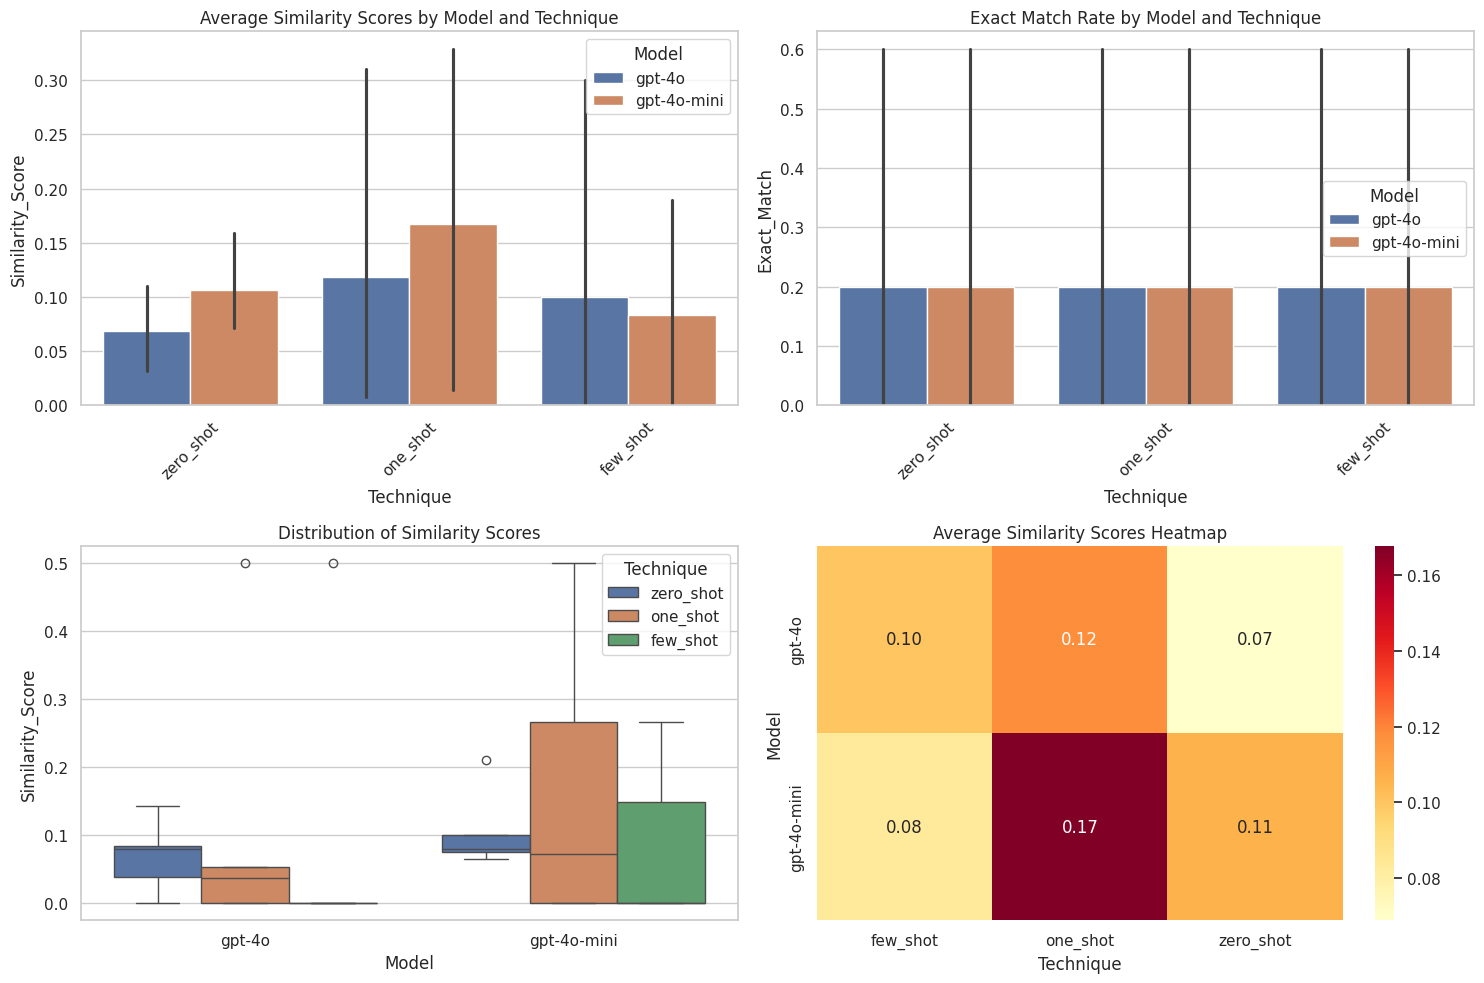


Accuracy Analysis Summary:
                       Avg_Similarity  Std_Similarity  Exact_Match_Rate
Model       Technique                                                  
gpt-4o      few_shot            0.100           0.224               0.2
            one_shot            0.118           0.215               0.2
            zero_shot           0.069           0.054               0.2
gpt-4o-mini few_shot            0.083           0.121               0.2
            one_shot            0.168           0.215               0.2
            zero_shot           0.106           0.060               0.2

Overall Model Performance:
             Similarity_Score  Exact_Match
Model                                     
gpt-4o                  0.096          0.2
gpt-4o-mini             0.119          0.2


In [ ]:
def plot_accuracy_comparison(df):
    """Create visualizations for accuracy comparison"""
     # Set the style for all plots
    sns.set_theme(style="whitegrid")

    # Set up the figure with multiple subplots
    fig = plt.figure(figsize=(15, 10))

    # 1. Average Similarity Scores by Model and Technique
    plt.subplot(2, 2, 1)
    sns.barplot(data=df, x='Technique', y='Similarity_Score', hue='Model')
    plt.title('Average Similarity Scores by Model and Technique')
    plt.xticks(rotation=45)

    # 2. Exact Match Rate by Model and Technique
    plt.subplot(2, 2, 2)
    sns.barplot(data=df, x='Technique', y='Exact_Match', hue='Model')
    plt.title('Exact Match Rate by Model and Technique')
    plt.xticks(rotation=45)

    # 3. Distribution of Similarity Scores
    plt.subplot(2, 2, 3)
    sns.boxplot(data=df, x='Model', y='Similarity_Score', hue='Technique')
    plt.title('Distribution of Similarity Scores')

    # 4. Heatmap of Average Similarity Scores
    plt.subplot(2, 2, 4)
    pivot_data = df.pivot_table(
        values='Similarity_Score',
        index='Model',
        columns='Technique',
        aggfunc='mean'
    )
    sns.heatmap(pivot_data, annot=True, cmap='YlOrRd', fmt='.2f')
    plt.title('Average Similarity Scores Heatmap')

    plt.tight_layout()
    plt.savefig('model_accuracy_comparison.png')
    plt.show()
    plt.close()

def generate_summary_stats(df):
    """Generate summary statistics"""
    summary = pd.DataFrame()

    # Average similarity scores
    similarity_summary = df.groupby(['Model', 'Technique'])['Similarity_Score'].agg(['mean', 'std']).round(3)

    # Exact match rates
    exact_match_summary = df.groupby(['Model', 'Technique'])['Exact_Match'].mean().round(3)

    summary = pd.concat([similarity_summary, exact_match_summary], axis=1)
    summary.columns = ['Avg_Similarity', 'Std_Similarity', 'Exact_Match_Rate']

    return summary

def main():
    # Load results
    results = load_results()

    # Analyze accuracy
    accuracy_df = analyze_accuracy(results)

    # Generate visualizations
    plot_accuracy_comparison(accuracy_df)

    # Generate summary statistics
    summary_stats = generate_summary_stats(accuracy_df)

    # Save summary statistics
    summary_stats.to_csv('accuracy_summary.csv')

    # Print summary
    print("\nAccuracy Analysis Summary:")
    print(summary_stats)

    # Calculate and print overall model performance
    print("\nOverall Model Performance:")
    overall_performance = accuracy_df.groupby('Model')[['Similarity_Score', 'Exact_Match']].agg({
        'Similarity_Score': 'mean',
        'Exact_Match': 'mean'
    }).round(3)
    print(overall_performance)

if __name__ == "__main__":
    main()